# 车流量预测

In [1]:
import torch
import numpy as np
import random
from IPython import display
from matplotlib import pyplot as plt
import torch.utils.data as Data
from PIL import Image
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import time
import pandas as pd
from sklearn.utils import shuffle
import math
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
train_path = './出租车流量预测数据集/NYC-stdn/volume_train.npz'
test_path = './出租车流量预测数据集/NYC-stdn/volume_test.npz'

数据预处理

In [2]:
volume_train = np.load(open(train_path, "rb"))["volume"]
volume_test = np.load(open(test_path, "rb"))["volume"]
volume_train = np.sum(volume_train.reshape(1920, 200, 2, 1), axis=2)
volume_test = np.sum(volume_test.reshape(960, 200, 2, 1), axis=2)

In [3]:
volume_train.shape, volume_test.shape

((1920, 200, 1), (960, 200, 1))

数据可视化

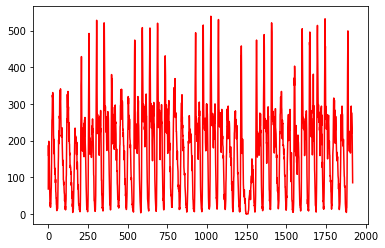

In [4]:
data_plot_in = volume_train[:, 1]
plt.plot(range(volume_train.shape[0]), data_plot_in, c='r')

In [5]:
# min-max归一化 将结果映射在[0, 1]
dmin, dmax = volume_train.min(), volume_train.max()
volume_train = (volume_train - dmin) / (dmax - dmin)

dmin, dmax = volume_test.min(), volume_test.max()
volume_test = (volume_test - dmin) / (dmax - dmin)

定义固定长度滑动窗口

In [6]:
def sliding_window(seq, window_size):
    result = []
    for i in range(len(seq) - window_size):
        result.append(seq[i: i + window_size])
    return result


加载数据

In [7]:

train_set, test_set = [], []
# for i in range(sensor_num):
train_set += sliding_window(volume_train, window_size=7)
test_set += sliding_window(volume_test, window_size=7)

train_set, test_set = np.array(train_set), np.array(test_set)
# train_set = np.swapaxes(train_set, 1, 2)
# test_set = np.swapaxes(test_set, 1, 2)
print(train_set.shape,test_set.shape)
print(train_set,test_set)

(1913, 7, 200, 1) (953, 7, 200, 1)
[[[[0.04876894]
   [0.03219697]
   [0.00852273]
   ...
   [0.00142045]
   [0.00047348]
   [0.        ]]

  [[0.09280303]
   [0.08854167]
   [0.01609848]
   ...
   [0.00189394]
   [0.00378788]
   [0.00757576]]

  [[0.109375  ]
   [0.07481061]
   [0.01515152]
   ...
   [0.00236742]
   [0.00189394]
   [0.0094697 ]]

  ...

  [[0.07339015]
   [0.0842803 ]
   [0.01325758]
   ...
   [0.00189394]
   [0.00331439]
   [0.00710227]]

  [[0.08617424]
   [0.07954545]
   [0.01751894]
   ...
   [0.00142045]
   [0.00331439]
   [0.00804924]]

  [[0.08285985]
   [0.06534091]
   [0.01420455]
   ...
   [0.00331439]
   [0.00520833]
   [0.00568182]]]


 [[[0.09280303]
   [0.08854167]
   [0.01609848]
   ...
   [0.00189394]
   [0.00378788]
   [0.00757576]]

  [[0.109375  ]
   [0.07481061]
   [0.01515152]
   ...
   [0.00236742]
   [0.00189394]
   [0.0094697 ]]

  [[0.09611742]
   [0.09375   ]
   [0.01751894]
   ...
   [0.00473485]
   [0.00094697]
   [0.00757576]]

  ...

  [[

定义CNN + GRU模型

In [8]:
device = 'cpu'
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=1, padding=0),
            nn.AvgPool2d((200, 1)),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        out = self.conv1(x)
        return out.squeeze()

Feature_extract = MyCNN()        
torch_gru = nn.GRU(input_size=1, hidden_size=32, num_layers=1, batch_first=True).to(device)
output_model = nn.Linear(32, 200).to(device)

初始化模型参数

In [9]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(list(torch_gru.parameters()) + list(output_model.parameters()), lr=0.0001)

定义评估函数

In [10]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

读取batch函数

In [11]:
def next_batch(data, batch_size):
    data_length = len(data)
    num_batches = math.ceil(data_length / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, data_length)
        yield data[start_index:end_index]

In [12]:
#反归一化
def denormalize(x):
    return x * (dmax - dmin) + dmin

训练函数

In [13]:
train_log = []
test_log = []
#开始时间
timestart = time.time()
trained_batches = 0 #记录多少个batch 
for epoch in range(100):
   
    total_1oss = 0 #记录Loss
    for batch in next_batch(shuffle(train_set), batch_size=128):
        #每一个batch的开始时间
        batchstart = time.time()
        
        batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
        # 使用短序列的前6个值作为历史，最后一个值作为预测值。
        x, label = batch[:, :6], batch[:, -1]
        
        x = Feature_extract(x)
        out, hidden = torch_gru(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
        out = output_model(out[:, -1, :])
        prediction = out.squeeze(-1)  # (batch)
        label = label.squeeze(-1)
     
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #correct += (prediction == label).sum().item()
        #累加loss
        #total_1oss += loss.item( )
        trained_batches += 1
         #计算平均oss与准确率
        #train_loss = total_1oss / train_batch_num
        #train_log.append(train_loss)   
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        #if trained_batches % 100 == 0:
        train_log.append(loss.detach().cpu().numpy().tolist());
        train_batch_time = (time.time() - batchstart)
        print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time))
    
        
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        if trained_batches % 100 == 0:
            #每一个batch的开始时间
            batch_test_start = time.time()
            #在每个epoch上测试
            all_prediction = []
            for batch in next_batch(test_set, batch_size=128):
                batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
                x, label = batch[:, :6], batch[:, -1]
        
                x = Feature_extract(x)
                out, hidden = torch_gru(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
                out = output_model(out[:, -1, :])
                prediction = out  # (batch)
                all_prediction.append(prediction.detach().cpu().numpy())

            all_prediction = np.concatenate(all_prediction)
            all_label = test_set[:, -1]
            all_label = all_label.squeeze()
            # 没有进行反归一化操作。
            #all_prediction = denormalize(all_prediction)
            #all_label = denormalize(all_label)
            # 计算测试指标。
            rmse_score = math.sqrt(mse(all_label, all_prediction))
            mae_score = mae(all_label, all_prediction)
            mape_score = mape(all_label, all_prediction)
            test_log.append([rmse_score, mae_score, mape_score])
            test_batch_time = (time.time() - batch_test_start)
            print('——test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time))
            
        #每一个epoch的结束时间
        #elapsed = (time.time() - epochstart)
   
#计算总时间
timesum = (time.time() - timestart)
print('The total time is %fs'%(timesum))
print('The total time is %fs'%(timesum))

batch 1, train_loss 0.025061,Time used 0.032363s
batch 2, train_loss 0.024446,Time used 0.018950s
batch 3, train_loss 0.024054,Time used 0.015956s
batch 4, train_loss 0.024234,Time used 0.017952s
batch 5, train_loss 0.026131,Time used 0.016955s
batch 6, train_loss 0.025211,Time used 0.015957s
batch 7, train_loss 0.023490,Time used 0.014961s
batch 8, train_loss 0.023400,Time used 0.013965s
batch 9, train_loss 0.023703,Time used 0.015957s
batch 10, train_loss 0.024515,Time used 0.016956s
batch 11, train_loss 0.025577,Time used 0.015957s
batch 12, train_loss 0.024274,Time used 0.011967s
batch 13, train_loss 0.024308,Time used 0.017959s
batch 14, train_loss 0.023470,Time used 0.015956s
batch 15, train_loss 0.023530,Time used 0.016957s
batch 16, train_loss 0.023877,Time used 0.014960s
batch 17, train_loss 0.023915,Time used 0.016955s
batch 18, train_loss 0.022737,Time used 0.016954s
batch 19, train_loss 0.022692,Time used 0.015958s
batch 20, train_loss 0.023776,Time used 0.015958s
batch 21,

## 绘制曲线进行评测

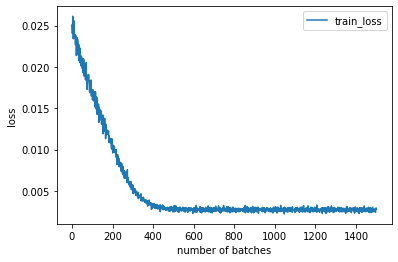

In [14]:
#train_loss曲线
x = np.linspace(0,len(train_log),len(train_log))
plt.plot(x,train_log,label="train_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches")
plt.ylabel("loss")
plt.legend()
plt.show()
#plt.clf()

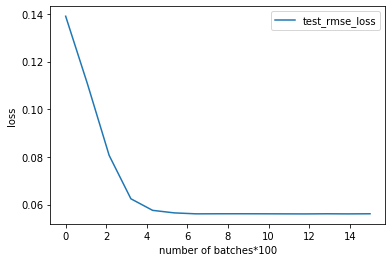

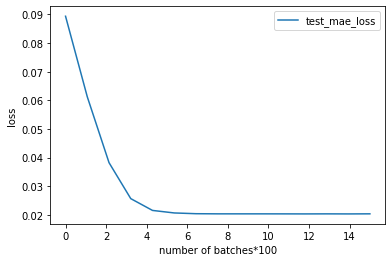

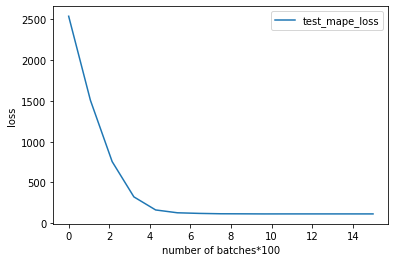

In [15]:
#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.show()
#plt.clf()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.show()
#plt.clf()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.show()
#plt.clf()